In [48]:
import sys
sys.path.append("../../../../../src")
import nanonets
import nanonets_utils
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.optimize import curve_fit
%matplotlib inline

plt.style.use(["science","bright"])

def capacitance(radius):
    factor  = 4*3.14159265359*8.85418781762039*0.001*3.9
    cap     = factor*radius
    return cap

def capacitance_m(np_radius1: float, np_radius2):
    d       = (np_radius1 + np_radius2 + 1.0)
    factor  = 4*3.14159265359*8.85418781762039*0.001*2.6*(np_radius1*np_radius2)/d
    # Paper approx sum_val = 1
    sum_val = sum([1,(np_radius1*np_radius2)/(d**2-2*np_radius1*np_radius2),
                    ((np_radius1**2)*(np_radius2**2))/(d**4-4*(d**2)*np_radius1*np_radius2+3*(np_radius1**2)*(np_radius2**2))])
    cap     = factor*sum_val

    return cap

def min_max_scale(arr, error):
    arr_max     = np.max(arr)
    arr_min     = np.min(arr)
    arr_new     = (arr-arr_min)/(arr_max-arr_min)
    error_new   = error / (arr_max - arr_min)
    return arr_new, error_new

def exp_func(x, a, b, c):
    return -a*np.exp(-b*x) + c

def exponential_decay(t, tau, a0):
    return a0 + (1 - a0) * np.exp(-t / tau)

def saturation_cuve(t, tau, a0, b0):
    return a0 - b0* np.exp(-t / tau)

def double_saturation_cuve(t, tau1, tau2, a0, b0, b1):
    return a0 - b0* np.exp(-t / tau1) - b1* np.exp(-t / tau2)

def power_law(x, a, b):
    return a*x**b

def stretched_saturation_curve(t, tau, a0, beta):
    return a0*(1 - np.exp(-((t)/tau)**beta))

def saturation_cuve(t, tau, a0, t0):
    return a0*(1 - np.exp(-(t-t0) / tau))

In [49]:
def capacitance(radius):
    factor  = 4*3.14159265359*8.85418781762039e-12*3.9
    cap     = factor*radius * 1e-9
    return cap*1e18

In [50]:
def capacitance(radius):
    factor  = 4*3.14159265359*8.85418781762039*0.001*3.9
    cap     = factor*radius
    return cap

In [51]:
def capacitance_m(np_radius1: float, np_radius2):
    np_radius1  = np_radius1*1e-9
    np_radius2  = np_radius2*1e-9
    d       = (np_radius1 + np_radius2 + 1e-9)
    factor  = 4*3.14159265359*8.85418781762039e-12*2.6*(np_radius1*np_radius2)/d
    # Paper approx sum_val = 1
    sum_val = sum([1,(np_radius1*np_radius2)/(d**2-2*np_radius1*np_radius2),
                    ((np_radius1**2)*(np_radius2**2))/(d**4-4*(d**2)*np_radius1*np_radius2+3*(np_radius1**2)*(np_radius2**2))])
    cap     = factor*sum_val

    return cap*1e18

In [52]:
capacitance(10)

4.339335218609398

In [53]:
capacitance_m(10,10)

2.2356807759548554

## String

In [54]:
folder  = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/time_scale/"
t_vals  = np.arange(9999)*1e-7*1e6
N_vals  = np.arange(2,13)
R_vals  = [1e1,1e2,1e3,1e4,1e5,1e6,1e7]

data_string     = {}
for N_p in N_vals:
    dic                 = {radius : pd.read_csv(f"{folder}Nx={N_p}_Ny=1_Nz=1_Ne=2_{i}.csv") for i, radius in enumerate(R_vals)}
    data_string[N_p]    = dic
states_string   = {R_vals[i] : pd.read_csv(f"{folder}mean_state_Nx=12_Ny=1_Nz=1_Ne=2_{i}.csv") for i in range(len(R_vals))}

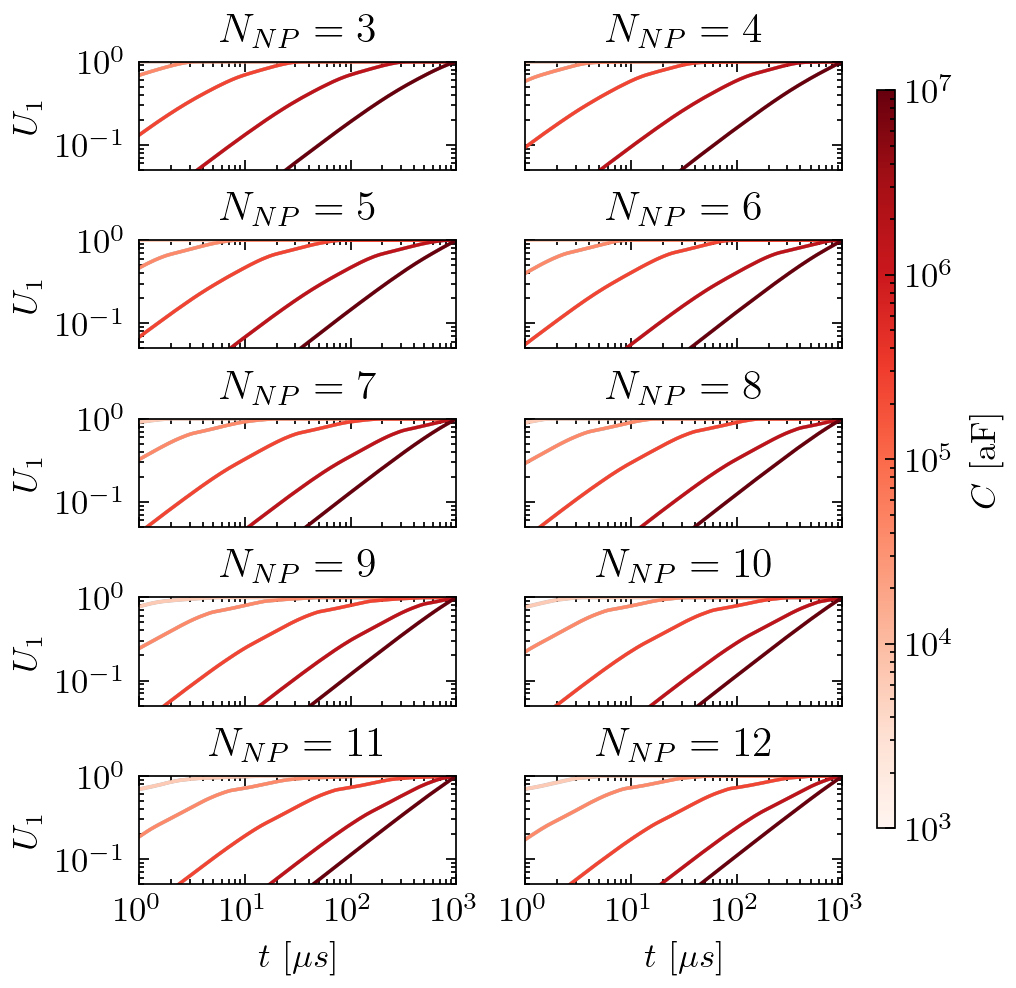

In [60]:
start       = 0
fig         = plt.figure(dpi=250, layout='constrained')
fig.set_figheight(fig.get_figheight()*1.5)
colormap    = 'Reds'
cmap        = plt.get_cmap(colormap)
R_vals_new  = [1e3,1e4,1e5,1e6,1e7]
N_row       = 5
N_col       = 2

for i, N_p in enumerate(N_vals[1:]):

    ax      = fig.add_subplot(N_row,N_col,i+1)

    for j, R_val in enumerate(R_vals_new):

        vals            = data_string[N_p][R_val].loc[start:,'Current'].values*1000
        error           = data_string[N_p][R_val].loc[start:,'Error'].values*1000
        vals_s, error_s = min_max_scale(vals, error)
        t_steps         = t_vals[start:]

        ax.plot(t_steps, vals_s, color=cmap((j+1)/len(R_vals_new)))
        ax.fill_between(t_vals, vals_s-error_s, vals_s+error_s, color='black', alpha=0.2)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1,1000)
    ax.set_ylim(0.05,1)

    if i >= N_row*N_col-N_col:
        ax.set_xlabel("$t$ [$\mu s$]")
    else:
        ax.set_xticklabels("")
    if i % N_col == 0:
        ax.set_ylabel("$U_1$")
    else:
        ax.set_yticklabels("")

    ax.set_title("$N_{NP} = "+f"{N_p}$")

cbar_ax = fig.add_axes([1., 0.16, 0.02, 0.75])
norm    = mpl.colors.LogNorm(vmin=R_vals_new[0], vmax=R_vals_new[-1])
cbar    = mpl.cm.ScalarMappable(norm=norm, cmap=colormap)
fig.colorbar(cbar, cax=cbar_ax, label='$C$ [aF]')
fig.savefig("../plots/step_input_response_vs_size.svg", transparent=True)
fig.savefig("../plots/step_input_response_vs_size.pdf", transparent=False)

In [56]:
start   = 0
stop    = 10000
R_new   = R_vals[1:]
N_new   = N_vals[0:]
a_vals  = np.zeros(shape=(len(N_new),len(R_new)))
b_vals  = np.zeros(shape=(len(N_new),len(R_new)))
c_vals  = np.zeros(shape=(len(N_new),len(R_new)))

for i, N_p in enumerate(N_new):
    for j, R_val in enumerate(R_new):
        x           = t_vals[start:stop].copy()
        y           = data_string[N_p][R_val]['Current'].values[start:stop].copy()
        # y           = nanonets_utils.standard_norm(y)
        p, cov      = curve_fit(saturation_cuve, x, y, maxfev=2000, p0=[1, 1, 1], bounds=[(0,0,0),(np.inf,1,1)])
        a_vals[i,j] = p[0]
        b_vals[i,j] = p[1]
        # c_vals[i,j] = p[2]

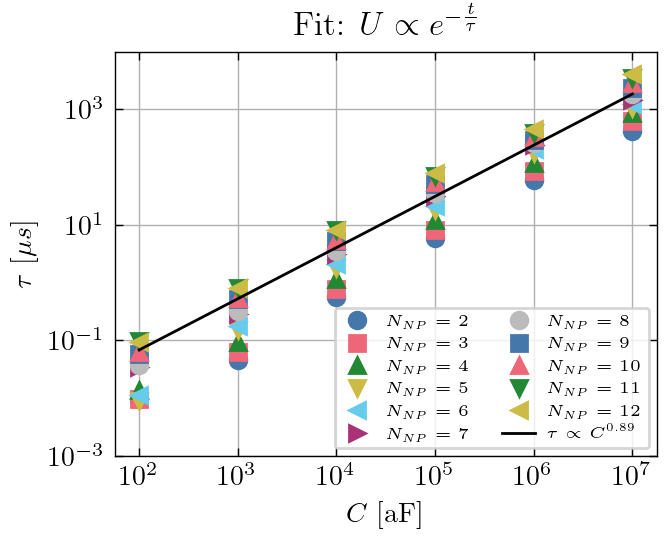

In [59]:
marker  = ['o','s','^','v','<','>']
df_time = pd.DataFrame(a_vals).T
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()

for i in range(len(N_new)):
    ax.plot(R_new, df_time.iloc[:,i].values, marker[i%len(marker)] ,label='$N_{NP} = '+f'{N_new[i]}$')

ax.set_title("Fit: $U \propto e^{-\\frac{t}{\\tau}}$")
ax.set_ylabel("$\\tau$ [$\mu s$]")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3,1e4)
ax.set_xticks(R_new)
ax.set_xlabel('$C$ [aF]')
ax.grid()

x_means = R_new[1:]
x_fit   = np.logspace(2,7)
y_means = df_time.iloc[1:,:].mean(axis=1).values
p, cov  = curve_fit(power_law, x_means, y_means, maxfev=10000)
ax.plot(x_fit, power_law(x_fit, *p), c='black',
        label='$\\tau \propto C^{'+f'{np.round(p[1],2)}'+'}$')
ax.legend(fontsize='xx-small', frameon=True, ncols=2)

fig.savefig("../plots/string_time_scales_vs_cap.svg", transparent=True)
fig.savefig("../plots/string_time_scales_vs_cap.pdf", transparent=False)

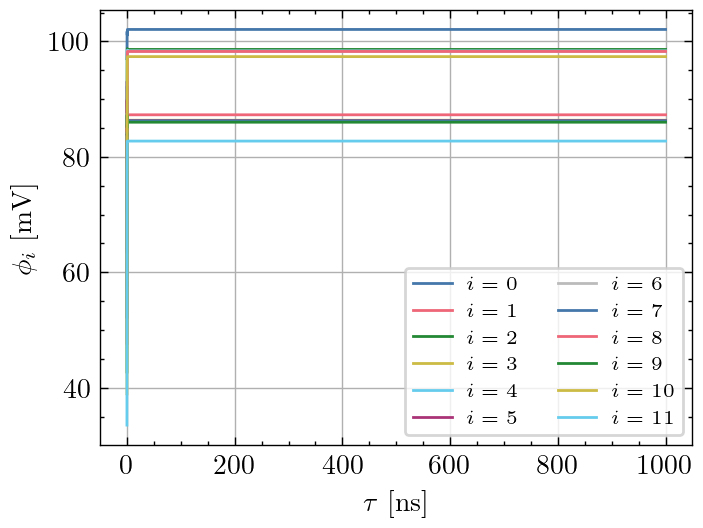

In [99]:
ms  = ['o','s','^','v','<','>']
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()
C_v = 1e2

for i in range(12):

    y   = states_string[C_v][f"{i}"].values*1000
    ax.plot(t_vals, y, label=f'$i = {i}$', ls='-')

ax.grid()
# ax.set_xlim(0,1000)
ax.legend(ncol=2, fontsize='x-small', frameon=True)
ax.set_xlabel("$\\tau$ [ns]")
ax.set_ylabel("$\phi_i$ [mV]")
fig.savefig(f"../plots/string_states_vs_time_{C_v}.svg", transparent=True, bbox_inches='tight')
fig.savefig(f"../plots/string_states_vs_time_{C_v}.pdf", transparent=False, bbox_inches='tight')

In [65]:
taus    = []
df      = states_string[1e6]
for i in range(13):
    y   = df[f"{i}"].values
    p,_ = curve_fit(saturation_cuve, t_vals, y)
    # p,_ = curve_fit(double_saturation_cuve, t_vals, y, maxfev=2000)
    taus.append(p[0])

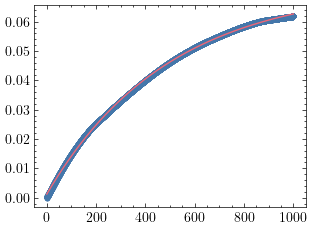

In [63]:
plt.plot(t_vals, y, '.')
plt.plot(t_vals, saturation_cuve(t_vals, *p))

Text(0, 0.5, '$\\tau_i$ [$\\mu s$]')

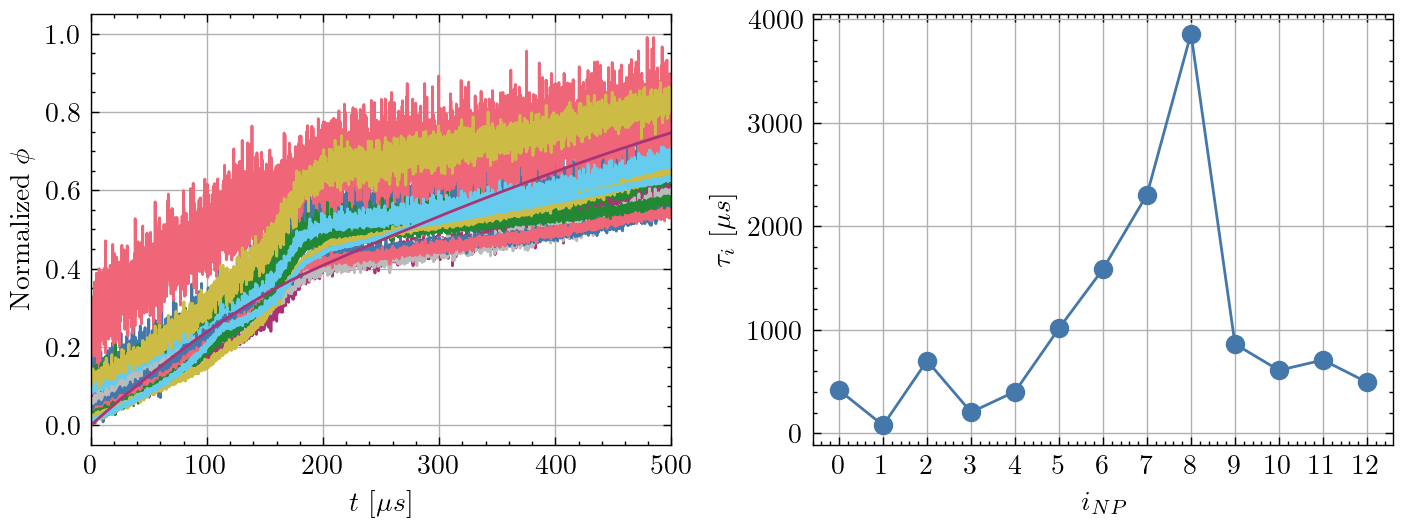

In [64]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)

for i in range(13):
    y   = df[f"{i}"].values
    y   = nanonets_utils.standard_norm(y)
    ax.plot(t_vals, y)

ax.set_ylabel("Normalized $\phi$")
ax.set_xlabel("$t$ [$\mu s$]")
ax.set_xlim(0,500)
ax.grid()

ax  = fig.add_subplot(1,2,2)
ax.plot(np.arange(len(taus)), taus, 'o-')
ax.grid()
ax.set_xticks(np.arange(len(taus)))
ax.set_xlabel("$i_{NP}$")
ax.set_ylabel("$\\tau_i$ [$\mu s$]")

## Network

In [100]:
folder  = "/home/j/j_mens07/mnt/j_mens07/data/2_funding_period/potential/time_scale/"
t_vals  = np.arange(19999)*1e-7*1e6
N_vals  = [3,5,7,9,11]
R_vals  = [1e1,1e2,1e3,1e4,1e5,1e6,1e7]

data    = {}
for N_p in N_vals:
    dic         = {radius : pd.read_csv(f"{folder}Nx={N_p}_Ny={N_p}_Nz=1_Ne=8_{i}.csv") for i, radius in enumerate(R_vals)}
    data[N_p]   = dic
x_vals  = data[3][1e1]['E0'].values

FileNotFoundError: [Errno 2] No such file or directory: '/home/j/j_mens07/mnt/j_mens07/data/2_funding_period/potential/time_scale/Nx=3_Ny=3_Nz=1_Ne=8_0.csv'

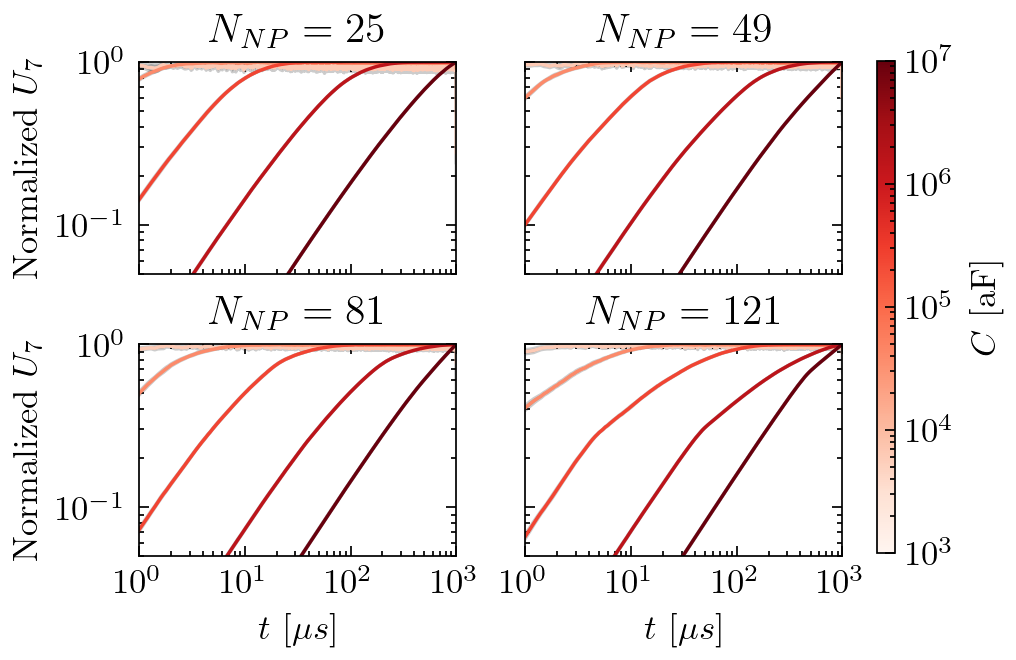

In [84]:
start       = 0
fig         = plt.figure(dpi=250, layout='constrained')
colormap    = 'Reds'
cmap        = plt.get_cmap(colormap)
R_vals_new  = [1e3,1e4,1e5,1e6,1e7]

for i, N_p in enumerate(N_vals[1:]):

    ax      = fig.add_subplot(2,2,i+1)

    for j, R_val in enumerate(R_vals_new):

        vals            = data[N_p][R_val].loc[start:,'Current'].values*1000
        error           = data[N_p][R_val].loc[start:,'Error'].values*1000
        vals_s, error_s = min_max_scale(vals, error)
        t_steps         = t_vals[start:]

        ax.plot(t_steps, vals_s, color=cmap((j+1)/len(R_vals_new)))
        ax.fill_between(t_vals, vals_s-error_s, vals_s+error_s, color='black', alpha=0.2)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1,1000)
    ax.set_ylim(0.05,1)

    if i >= 2:
        ax.set_xlabel("$t$ [$\mu s$]")
    else:
        ax.set_xticklabels("")
    if i % 2 == 0:
        ax.set_ylabel("Normalized $U_7$")
    else:
        ax.set_yticklabels("")

    ax.set_title("$N_{NP} = "+f"{N_p**2}$")

cbar_ax = fig.add_axes([1., 0.16, 0.02, 0.75])
norm    = mpl.colors.LogNorm(vmin=R_vals_new[0], vmax=R_vals_new[-1])
cbar    = mpl.cm.ScalarMappable(norm=norm, cmap=colormap)
fig.colorbar(cbar, cax=cbar_ax, label='$C$ [aF]')
fig.savefig("../plots/step_input_response_vs_size.svg", transparent=True)
fig.savefig("../plots/step_input_response_vs_size.pdf", transparent=False)

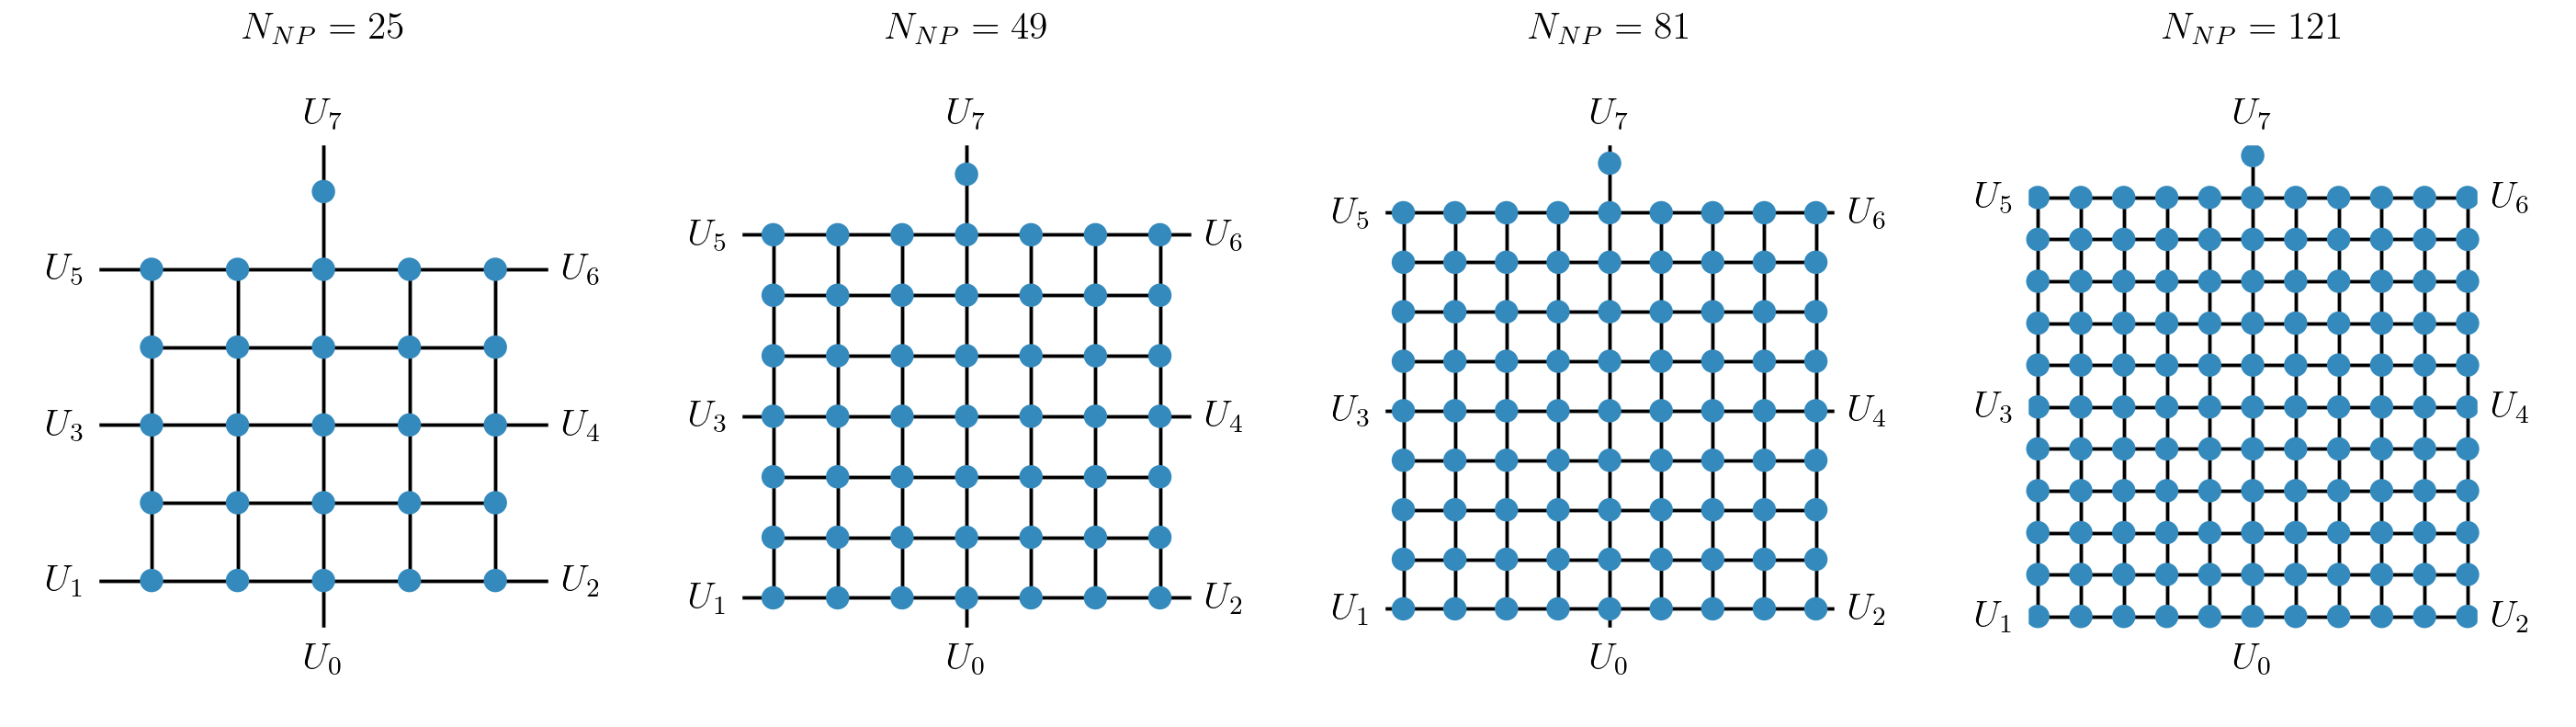

In [3]:
fig = plt.figure(dpi=250, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*3.2)
fig.set_figheight(fig.get_figheight()*1.2)

for i, N_p in enumerate(N_vals[1:]):
    ax                  = fig.add_subplot(1,4,i+1)
    topology_parameter  = {
        "Nx"                : N_p,
        "Ny"                : N_p,
        "Nz"                : 1,
        "e_pos"             : [[(N_p-1)//2,0,0],[0,0,0],[N_p-1,0,0],
                                [0,(N_p-1)//2,0],[N_p-1,(N_p-1)//2,0],
                                [0,N_p-1,0],[N_p-1,N_p-1,0],[(N_p-1)//2,N_p-1,0]],
        "electrode_type"    : ['constant','constant','constant',
                                'constant','constant','constant',
                                'constant','floating']
    }

    sim_class   = nanonets.simulation(topology_parameter=topology_parameter)
    fig, ax     = nanonets_utils.display_network(np_network_sim=sim_class, fig=fig, ax=ax, node_size=40,
                                                 provide_electrode_labels=[f"$U_{i}$" for i in range(8)], font_size=12)
    ax.set_title("$N_{NP} = "+f"{N_p**2}$")

fig.savefig("../plots/step_input_response_networks.svg", transparent=True)
fig.savefig("../plots/step_input_response_networks.pdf", transparent=False)

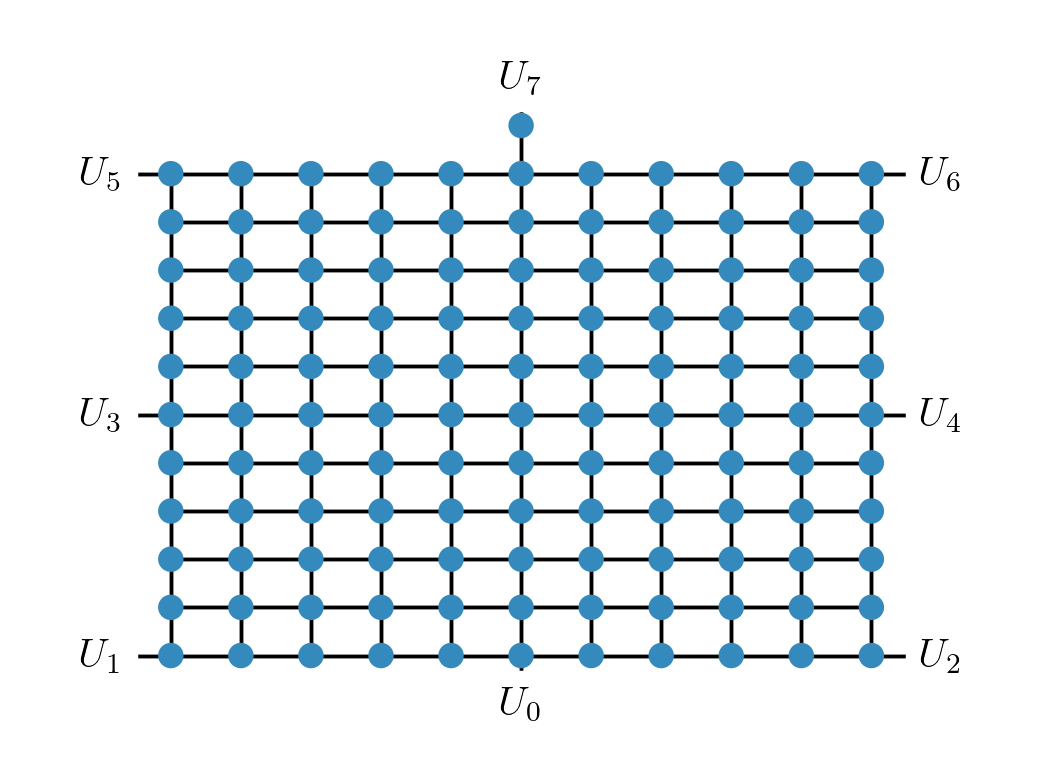

In [6]:
fig = plt.figure(dpi=250)
fig.set_figwidth(fig.get_figwidth()*1.5)
fig.set_figheight(fig.get_figheight()*1.5)
N_p = 11

ax                  = fig.add_subplot()
topology_parameter  = {
    "Nx"                : N_p,
    "Ny"                : N_p,
    "Nz"                : 1,
    "e_pos"             : [[(N_p-1)//2,0,0],[0,0,0],[N_p-1,0,0],
                            [0,(N_p-1)//2,0],[N_p-1,(N_p-1)//2,0],
                            [0,N_p-1,0],[N_p-1,N_p-1,0],[(N_p-1)//2,N_p-1,0]],
    "electrode_type"    : ['constant','constant','constant',
                            'constant','constant','constant',
                            'constant','floating']
}

sim_class   = nanonets.simulation(topology_parameter=topology_parameter)
fig, ax     = nanonets_utils.display_network(np_network_sim=sim_class, fig=fig, ax=ax, node_size=40,
                                                provide_electrode_labels=[f"$U_{i}$" for i in range(8)], font_size=12)

fig.savefig("../plots/step_input_example_net.svg", transparent=True)
fig.savefig("../plots/step_input_example_net.pdf", transparent=False)

In [68]:
start   = 10
stop    = 10000
R_new   = R_vals[0:]
N_new   = N_vals[1:]
a_vals  = np.zeros(shape=(len(N_new),len(R_new)))
b_vals  = np.zeros(shape=(len(N_new),len(R_new)))
c_vals  = np.zeros(shape=(len(N_new),len(R_new)))

for i, N_p in enumerate(N_new):
    for j, R_val in enumerate(R_new):
        x           = t_vals[start:stop].copy()
        y           = data[N_p][R_val]['Current'].values[start:stop].copy()
        p, cov      = curve_fit(exp_func, x, y, maxfev=2000)
        a_vals[i,j] = p[0]
        b_vals[i,j] = p[1]
        c_vals[i,j] = p[2]

/tmp/ipykernel_16935/1505061798.py:2: RuntimeWarning: overflow encountered in exp
  return -a*np.exp(-b*x) + c


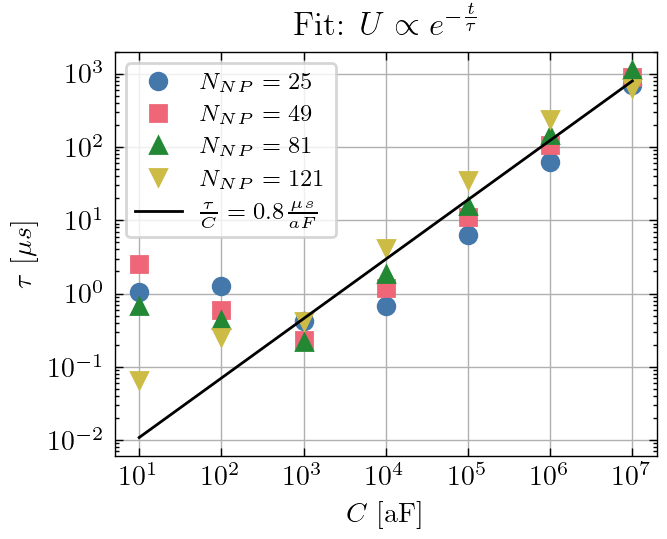

In [70]:
marker  = ['o','s','^','v']
df_time = pd.DataFrame(1/b_vals).T
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()

for i in range(len(N_new)):
    ax.plot(R_new, df_time.iloc[:,i].values, marker[i] ,label='$N_{NP} = '+f'{N_new[i]**2}$')

ax.set_title("Fit: $U \propto e^{-\\frac{t}{\\tau}}$")
ax.set_ylabel("$\\tau$ [$\mu s$]")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks(R_new)
ax.set_xlabel('$C$ [aF]')
ax.grid()

x_means = R_new[2:]
x_fit   = np.logspace(1,7)
y_means = df_time.iloc[2:,:].median(axis=1).values
p, cov  = curve_fit(power_law, x_means, y_means, maxfev=10000)
ax.plot(x_fit, power_law(x_fit, *p), c='black',
        label='$\\frac{\\tau}{C} = '+f'{np.round(p[1],1)}$'+'$ \\frac{\mu s}{aF}$')
ax.legend(fontsize='small', frameon=True, ncols=1)

fig.savefig("../plots/time_scales_vs_cap.svg", transparent=True)
fig.savefig("../plots/time_scales_vs_cap.pdf", transparent=False)

---

In [85]:
STOP

NameError: name 'STOP' is not defined

[8.23718230e-03 1.66668278e+01 1.63314727e-02]


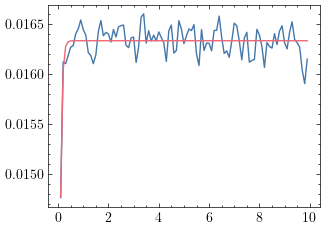

In [13]:
# N_p     = 5
# R_val   = 1e3
# start   = 1
# stop    = 100
# x       = t_vals[start:stop].copy()
# y       = data[N_p][R_val]['Current'].values[start:stop].copy()
# p, cov  = curve_fit(func3, x, y, maxfev=2000)
# print(p)

# plt.plot(x, y)
# plt.plot(x, func3(x,*p))